找到 38 个CSV文件...
成功预处理 38 场洪水事件。

--- 正在为组 '全局共享' 优化特征单位线 (38 场) ---
  单位线长度: 55
  使用权重: 平滑=0.1, 单峰罚=100.0
  优化成功

--- 基于NSE=0.5的二次分类结果 ---
拟合良好组事件数量: 21 场
拟合较差组事件数量: 17 场

--- 正在为组 '拟合良好组' 优化特征单位线 (21 场) ---
  单位线长度: 55
  使用权重: 平滑=0.05, 单峰罚=50.0
  优化成功

--- 正在为组 '拟合较差组' 优化特征单位线 (17 场) ---
  单位线长度: 49
  使用权重: 平滑=0.2, 单峰罚=500.0
  优化成功

--- 正在为每一场洪水生成最终的拟合对比图 ---


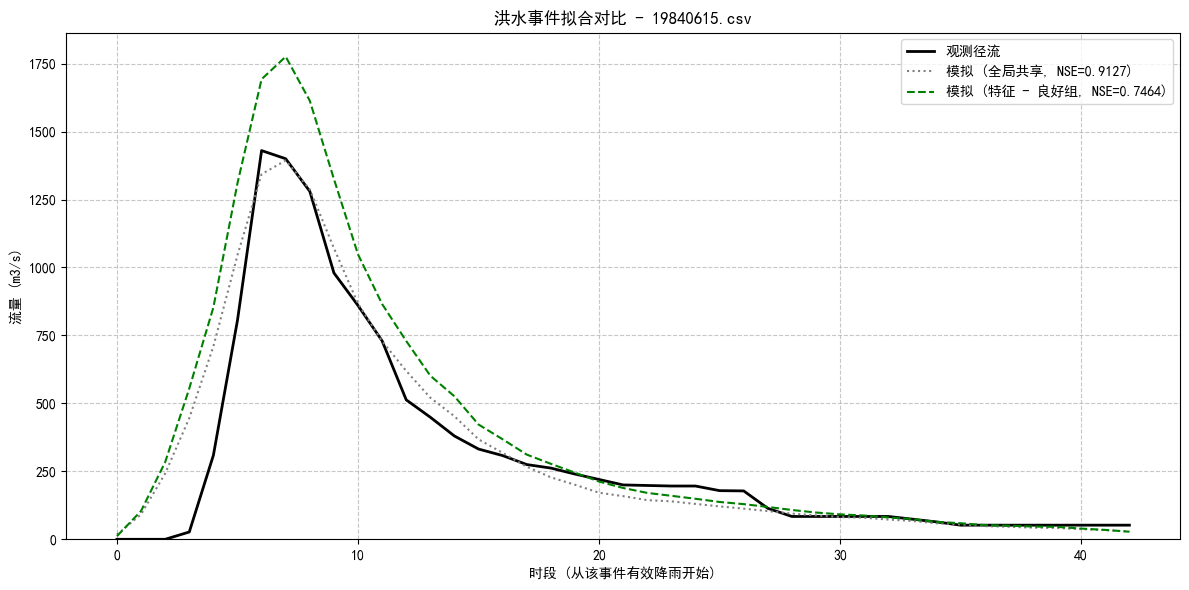

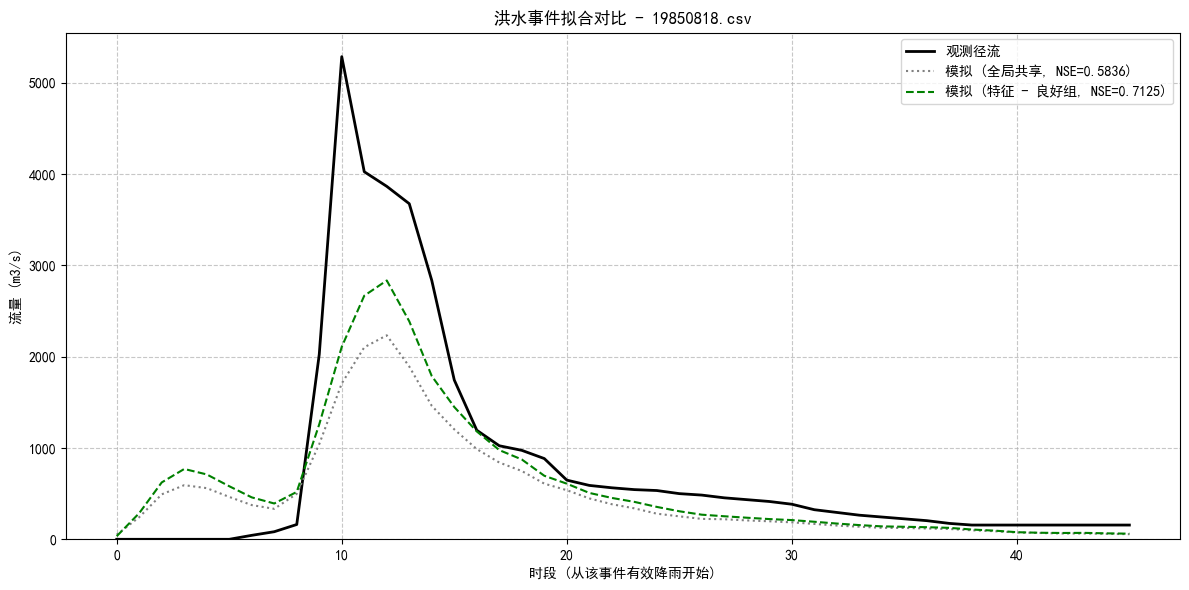

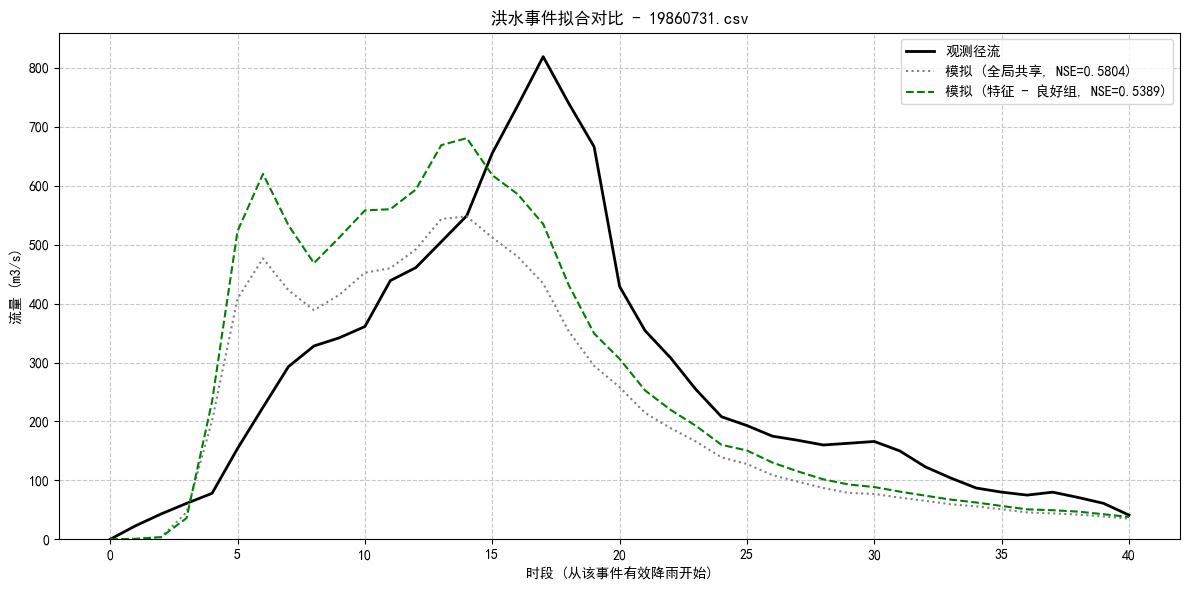

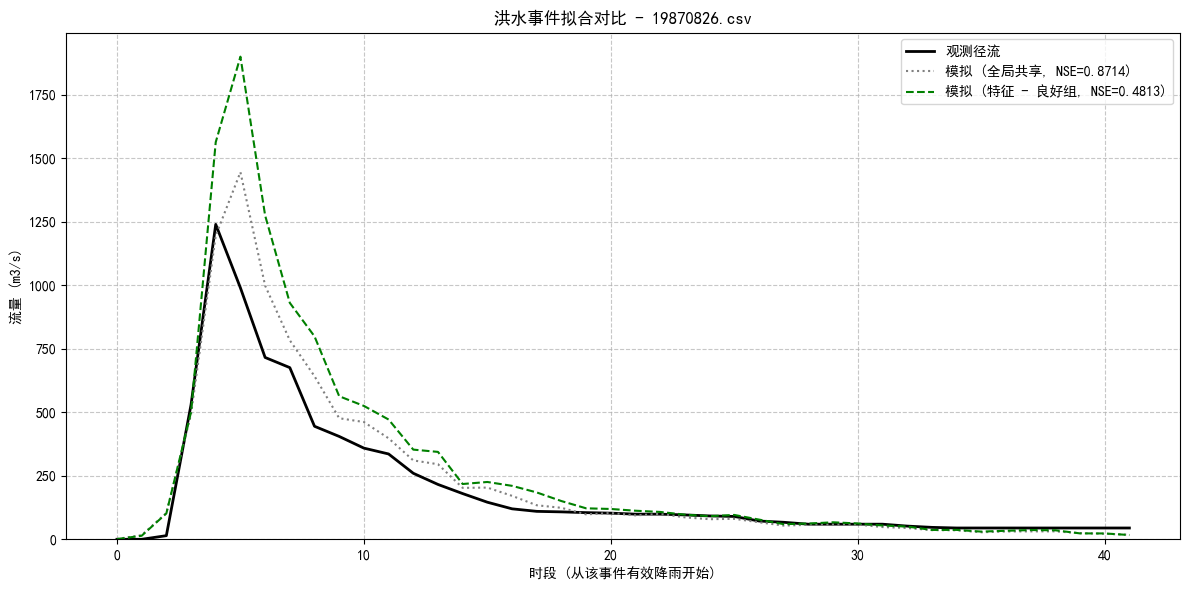

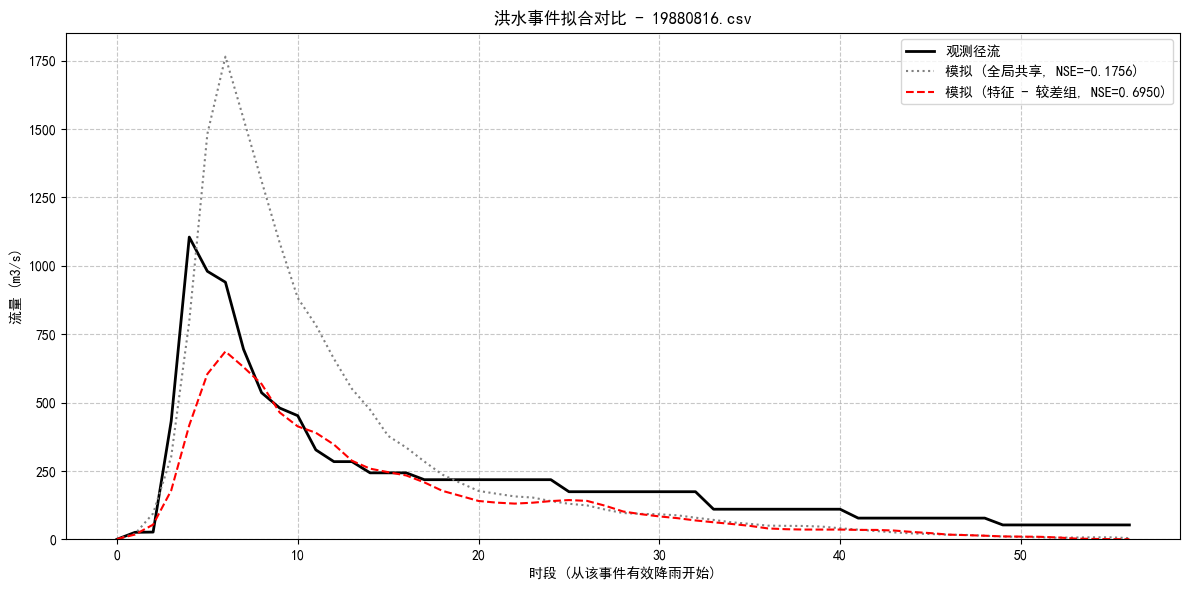

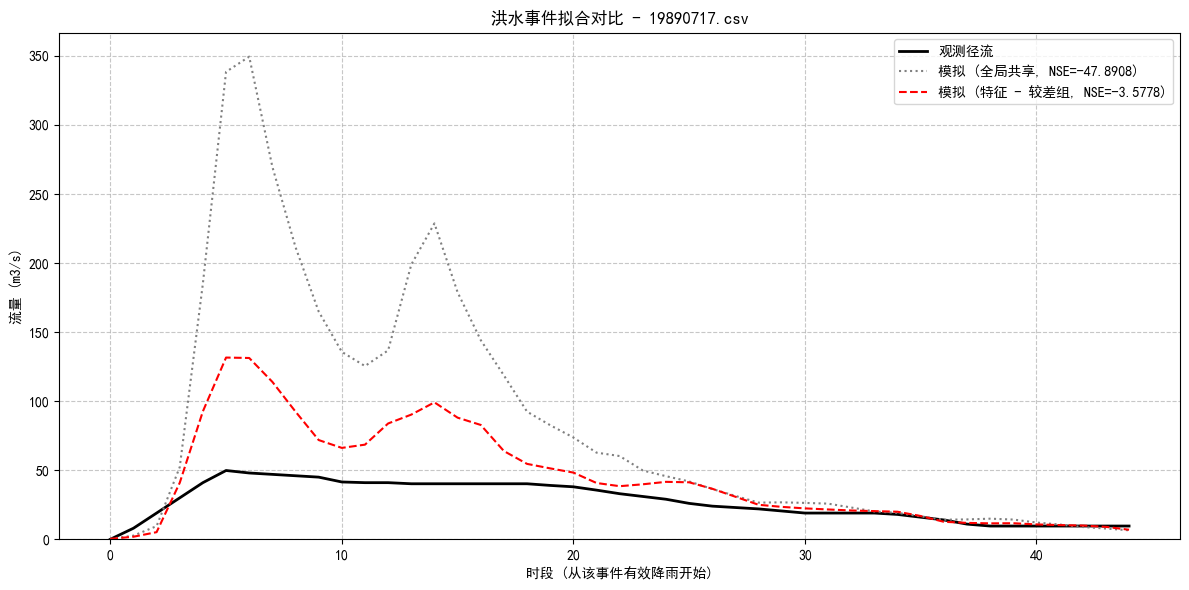

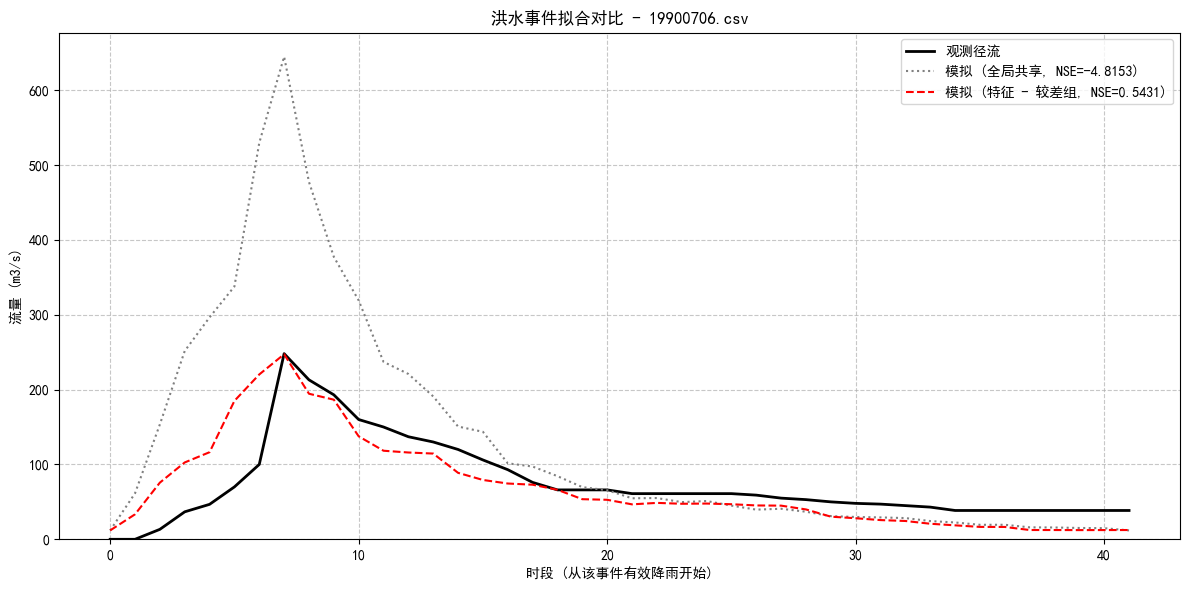

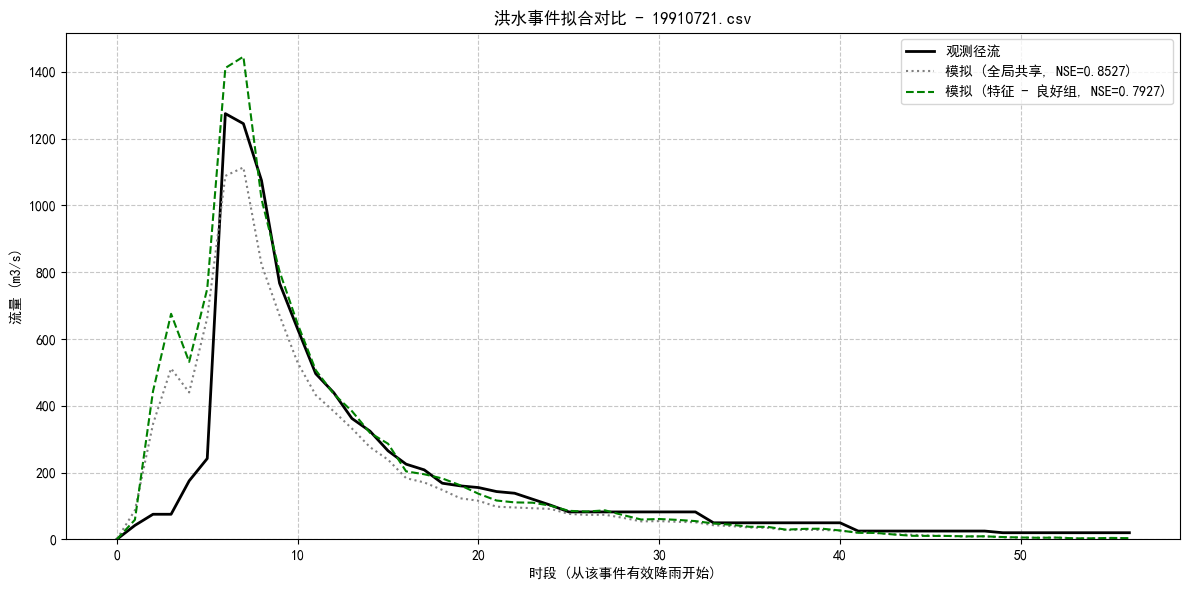

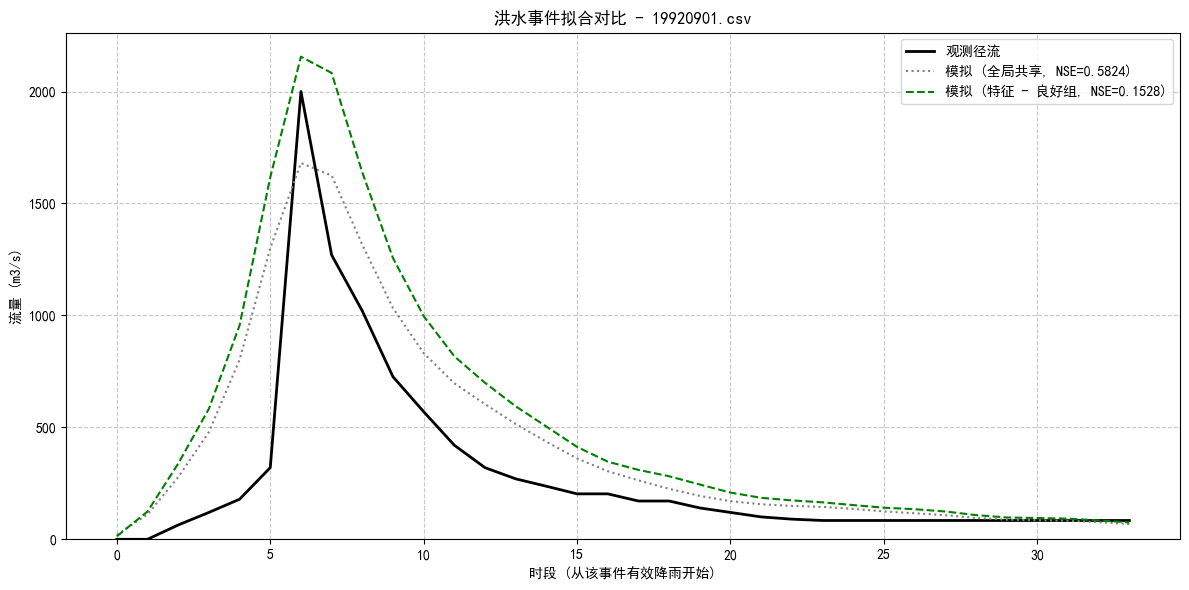

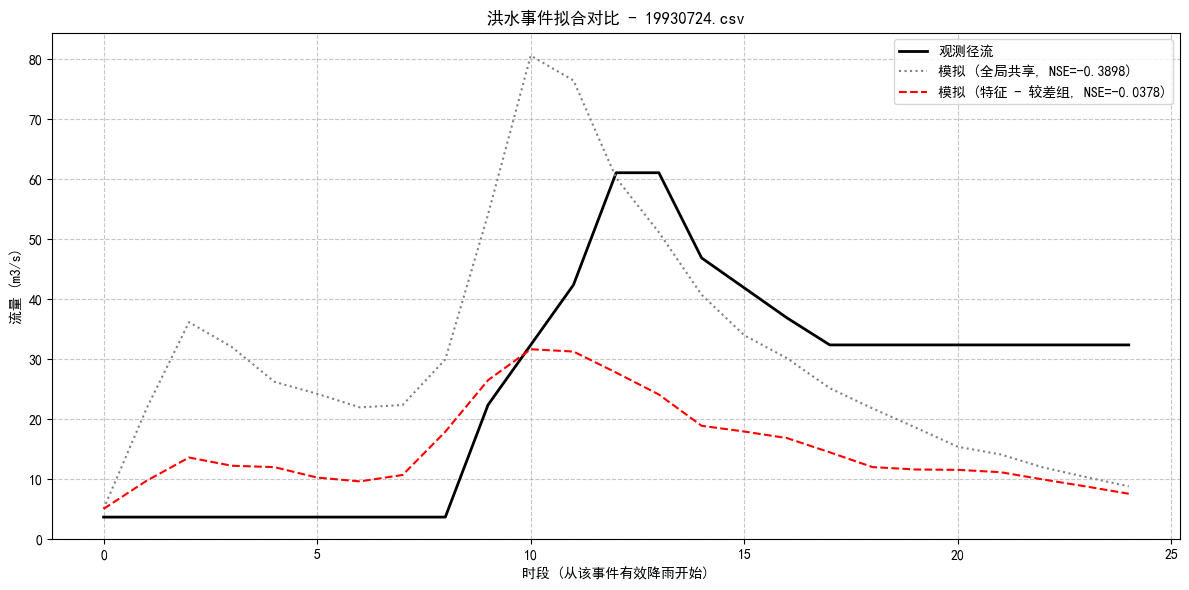

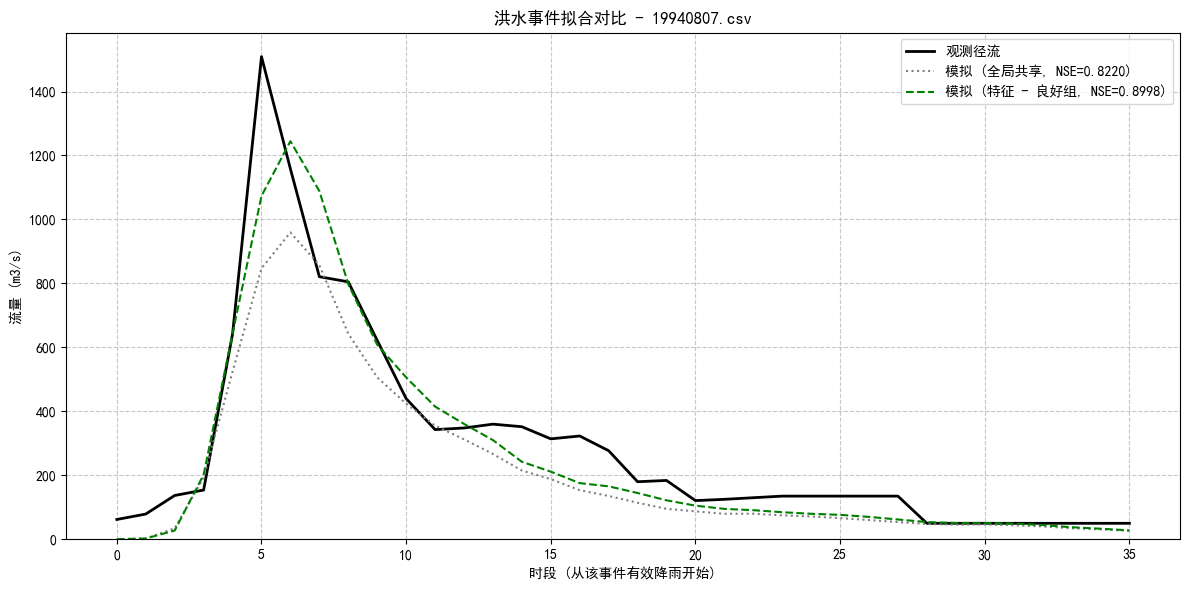

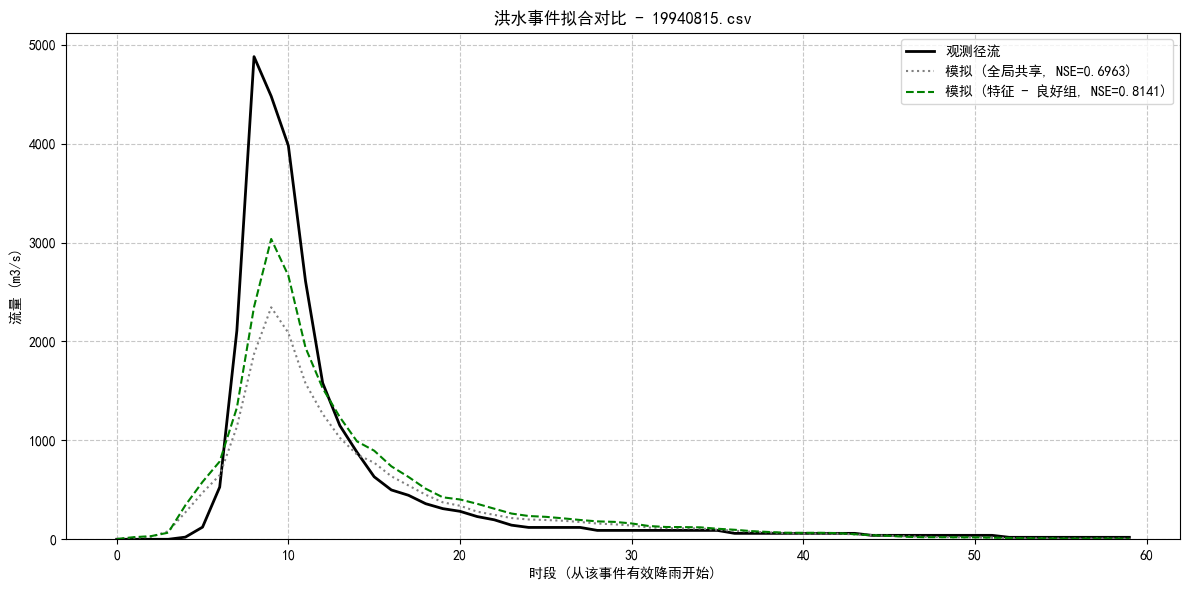

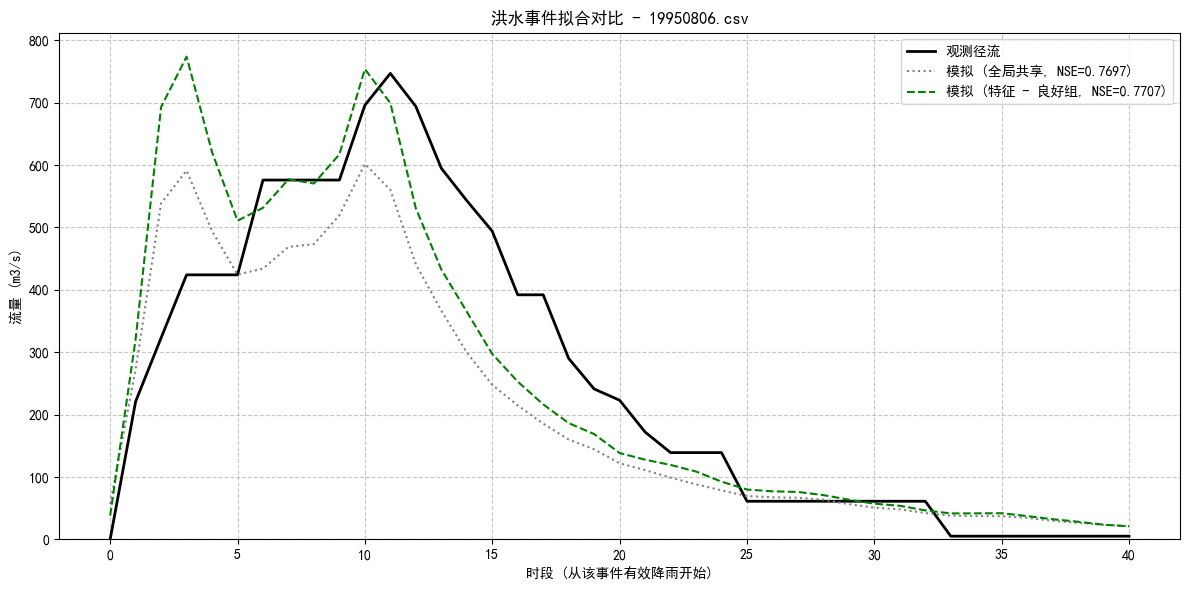

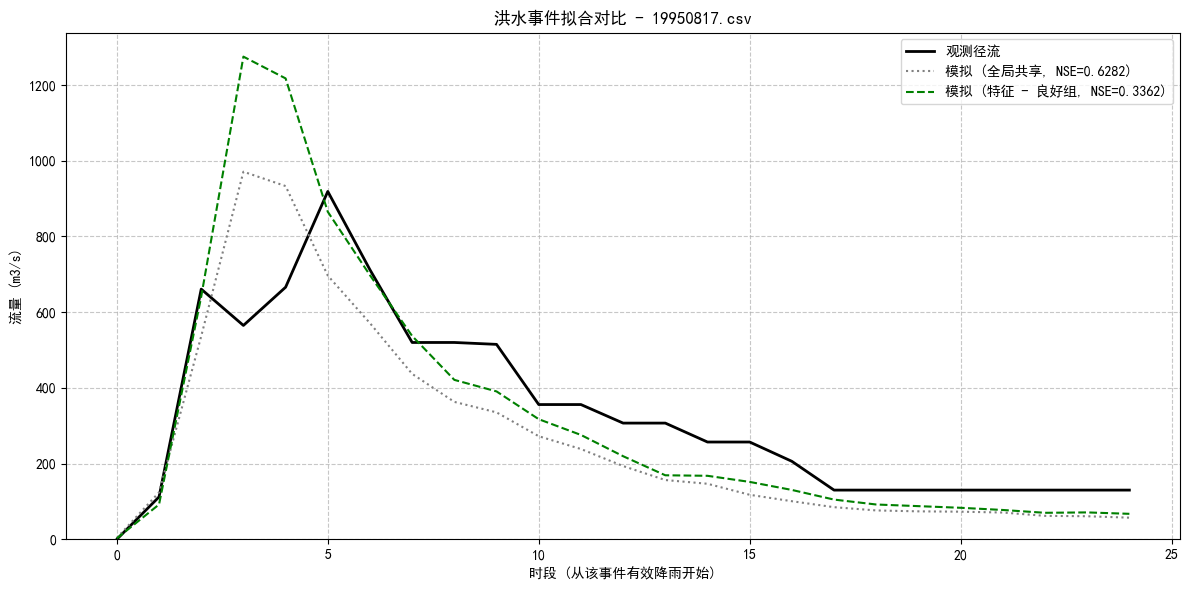

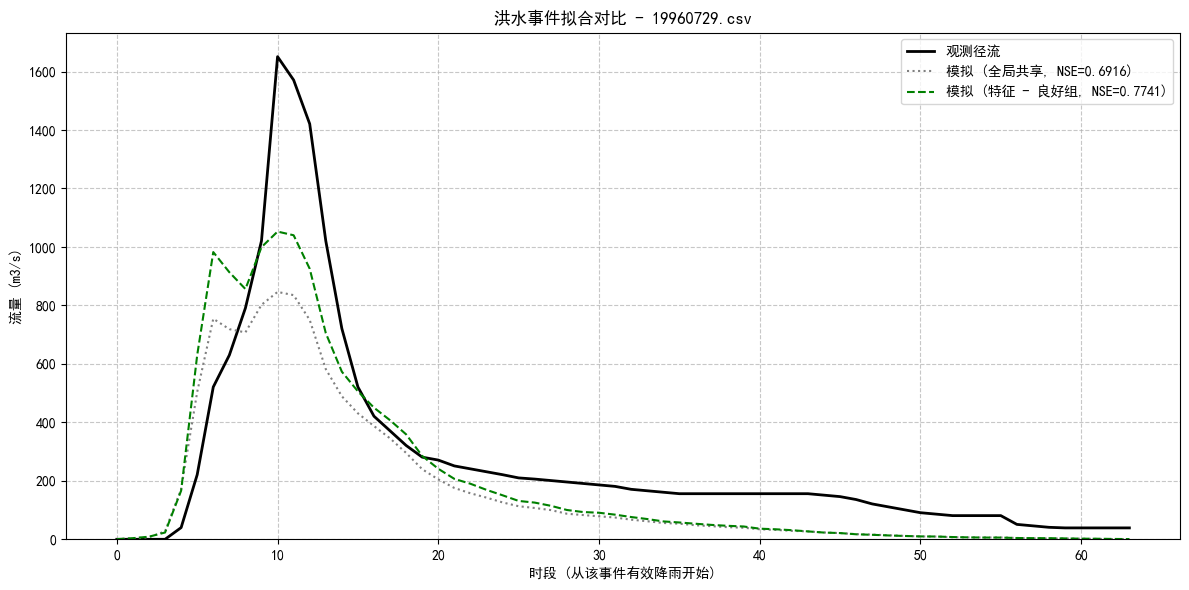

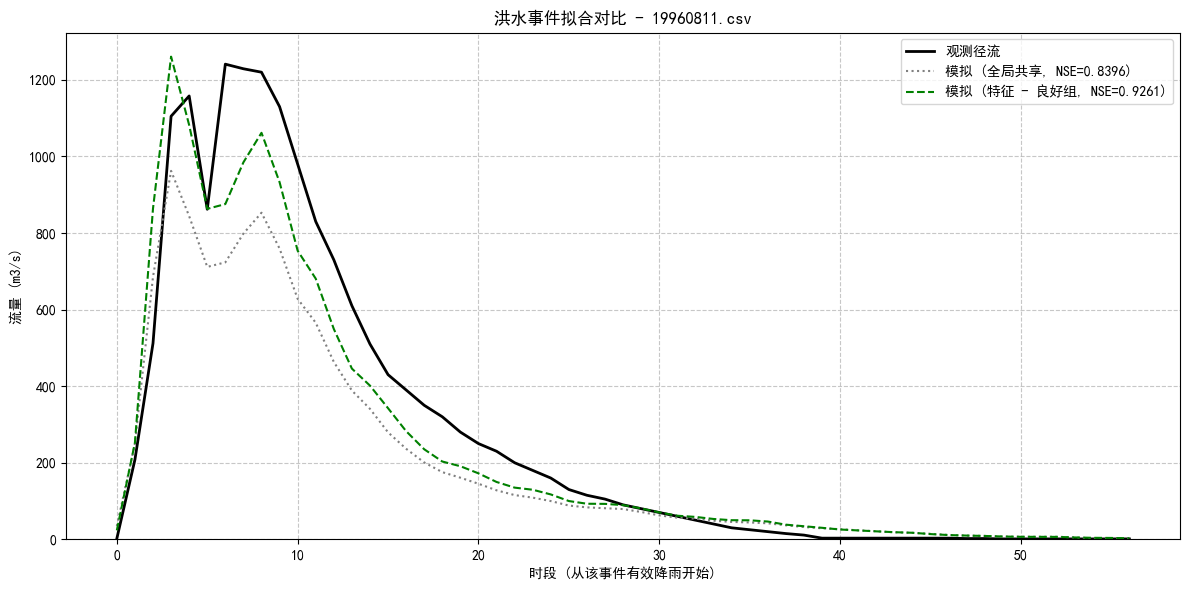

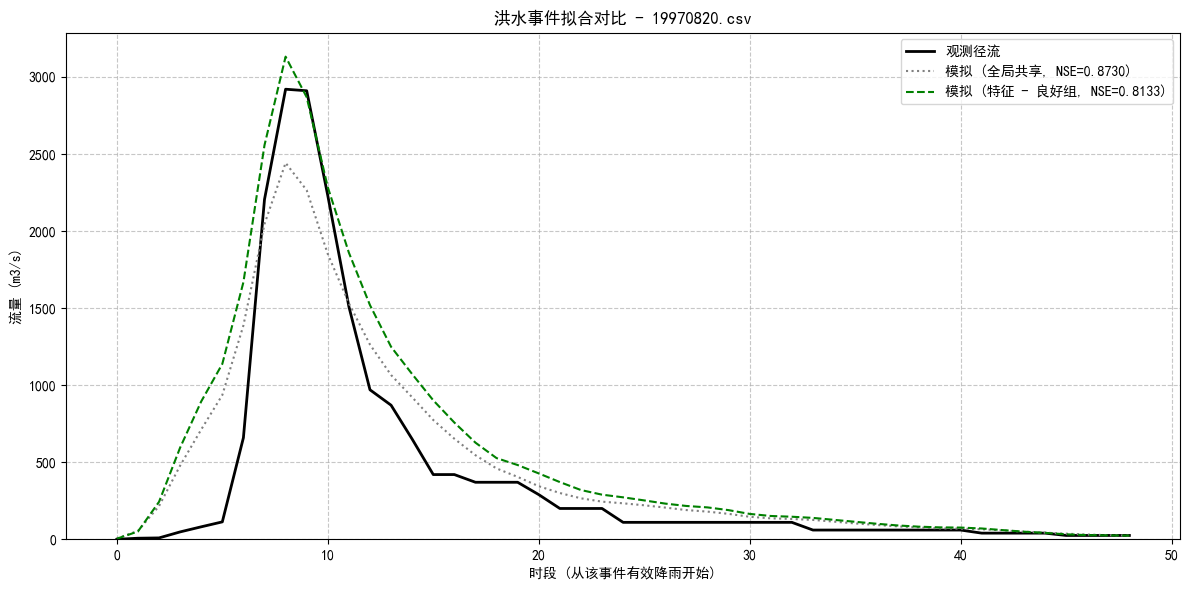

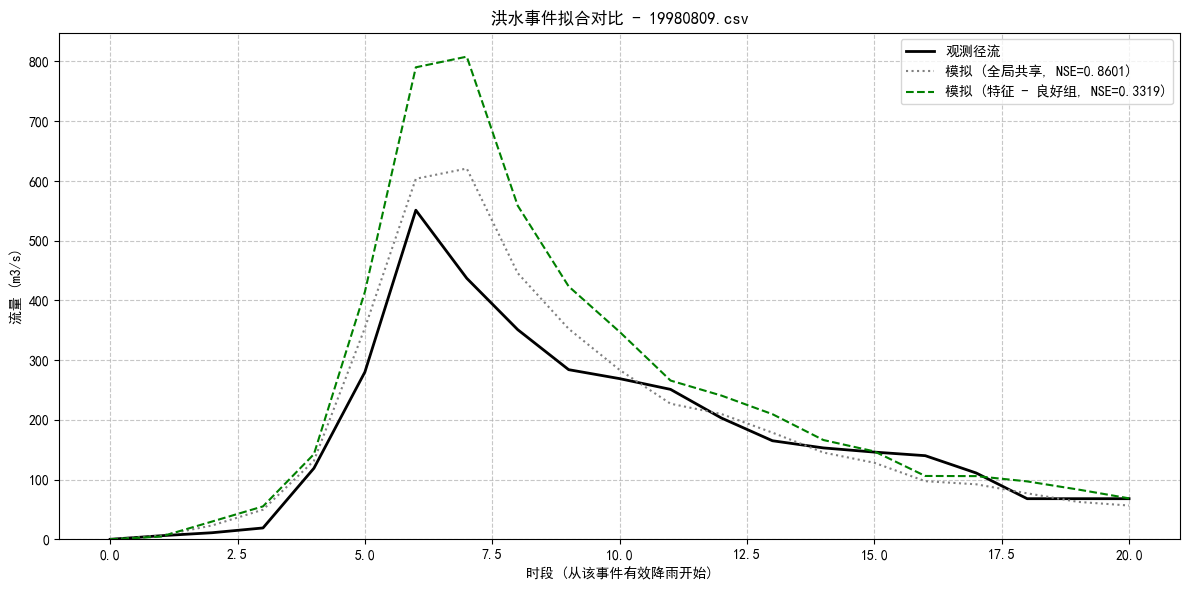

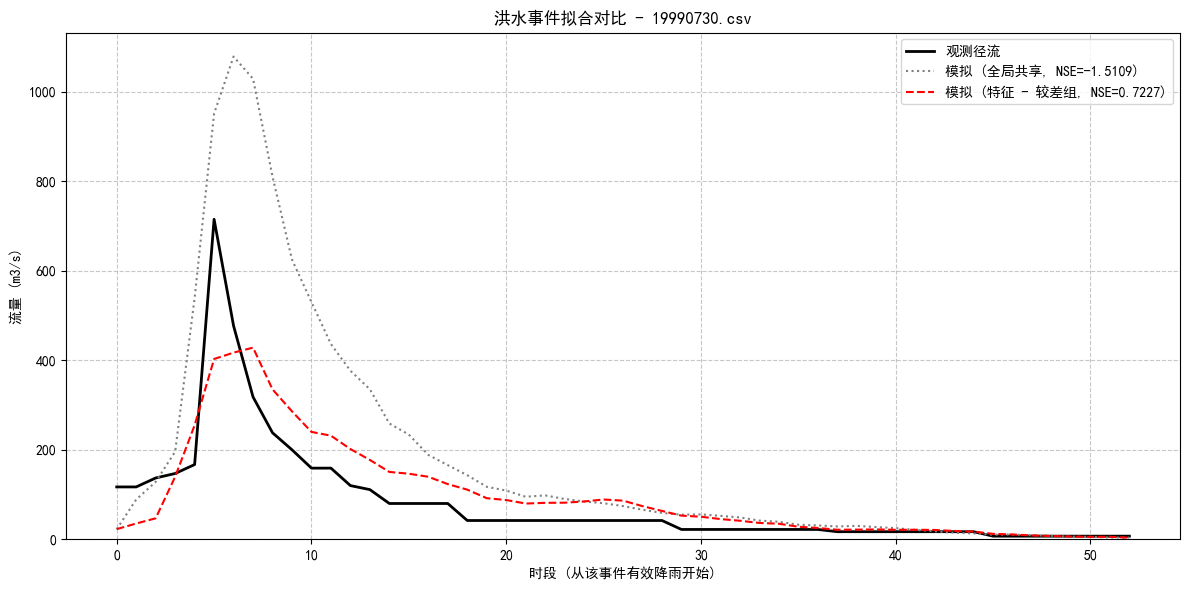

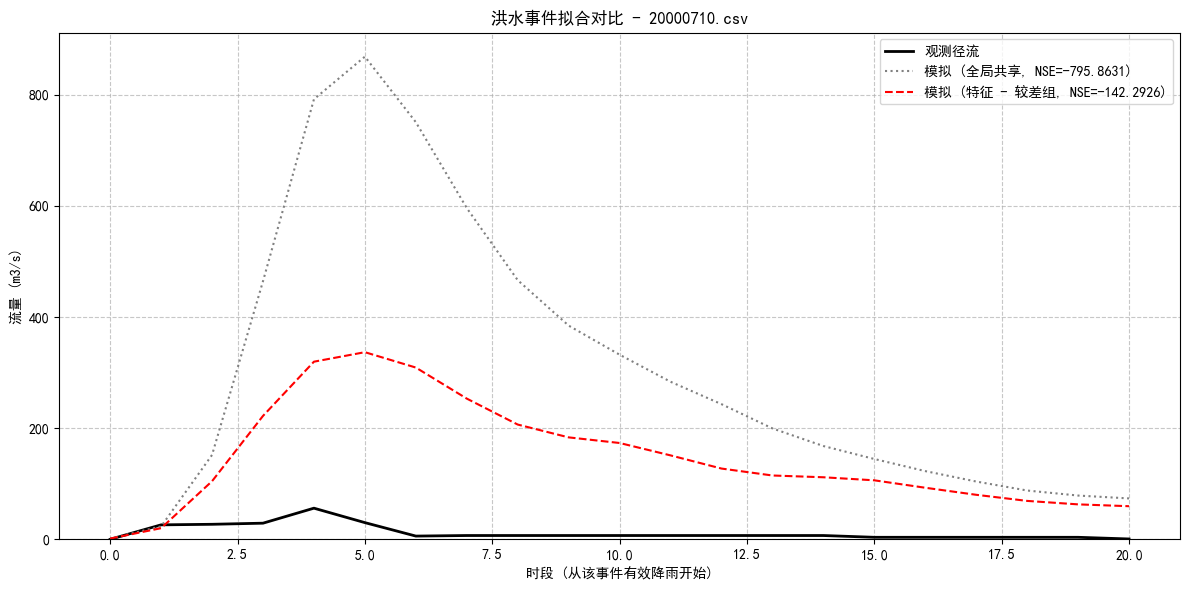

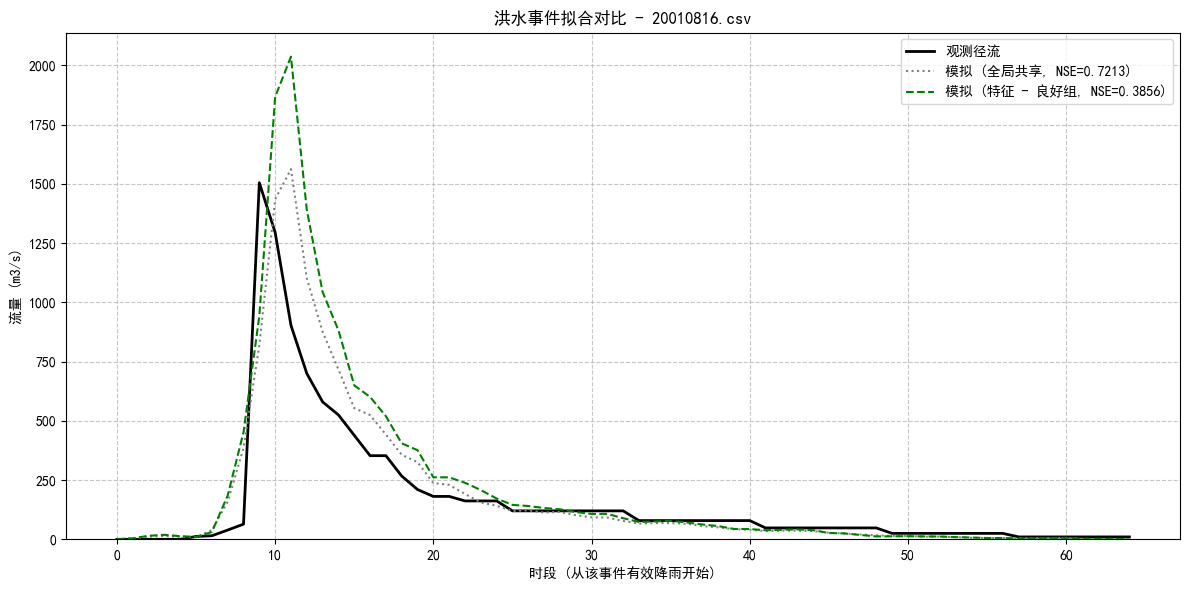

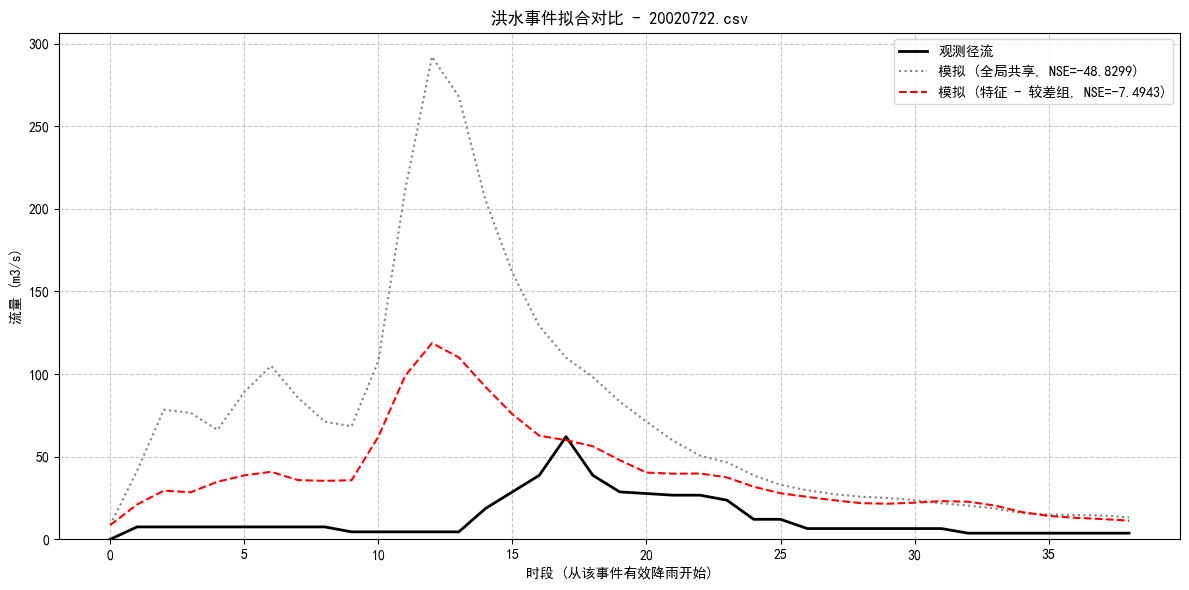

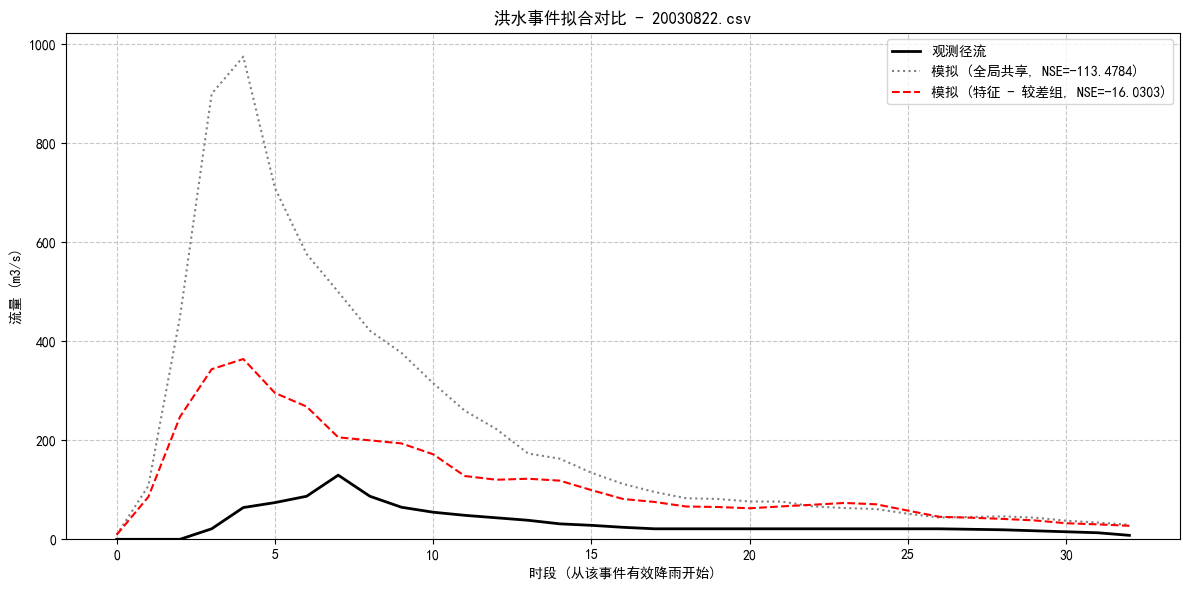

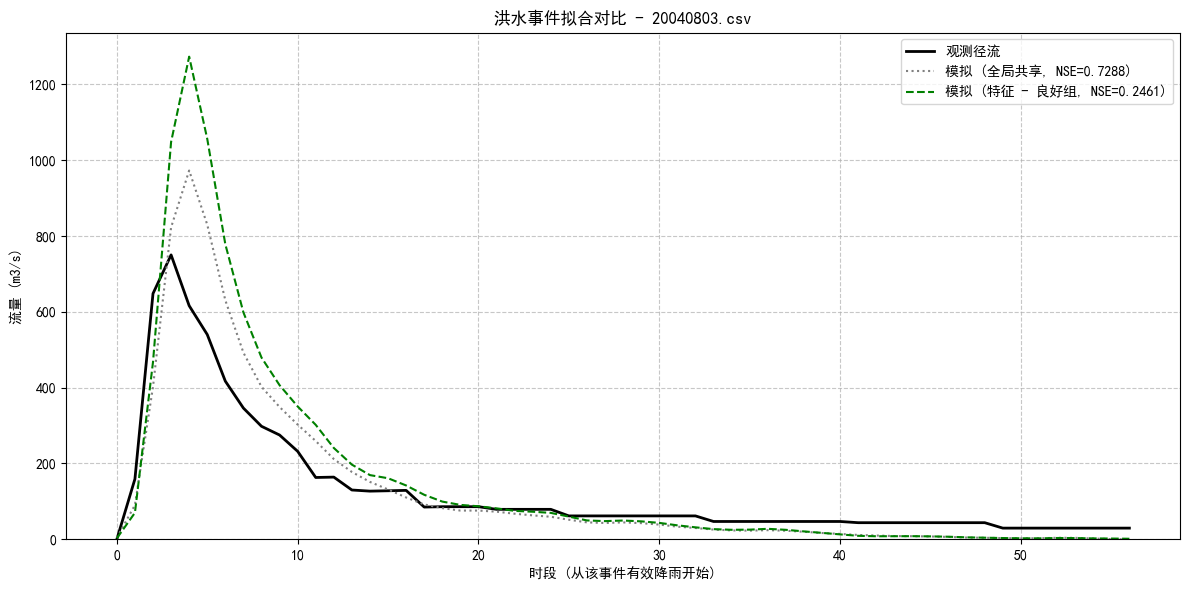

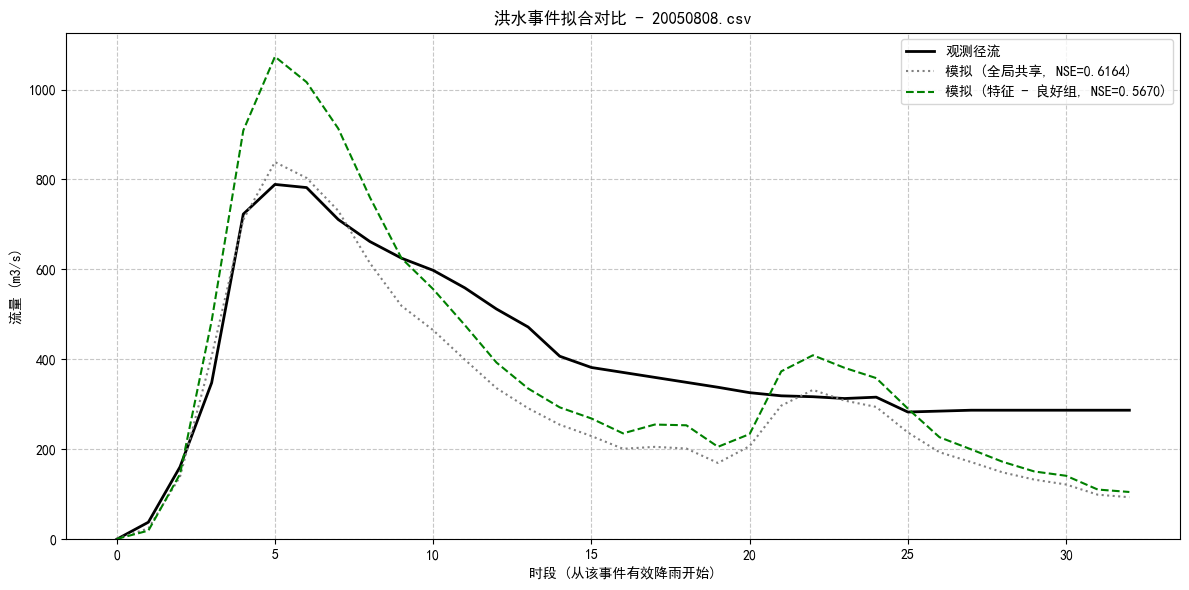

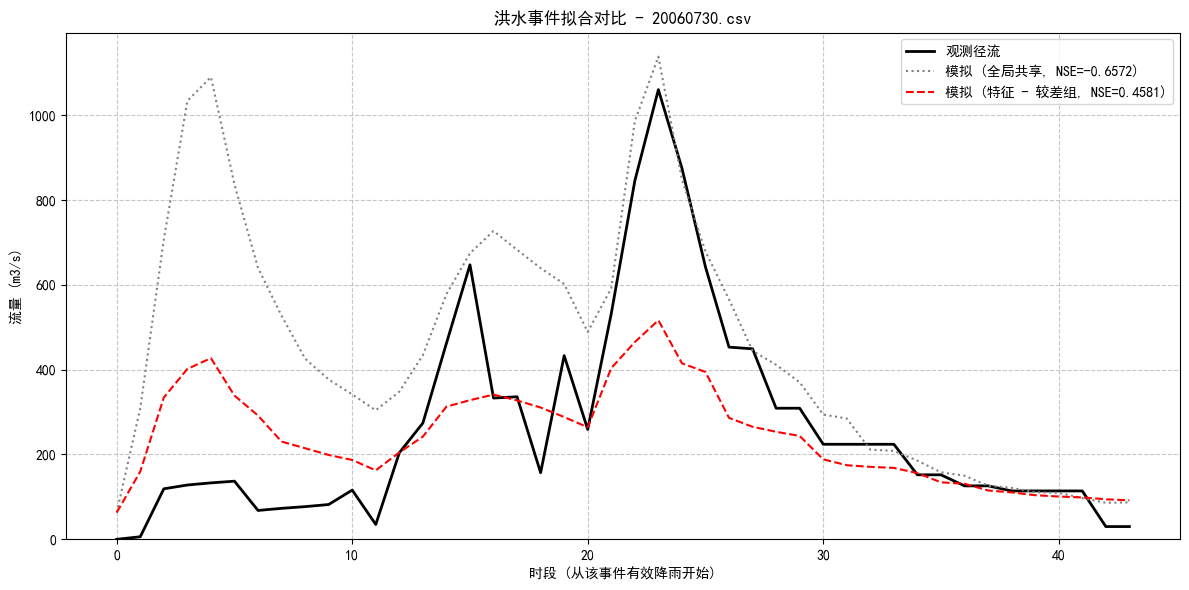

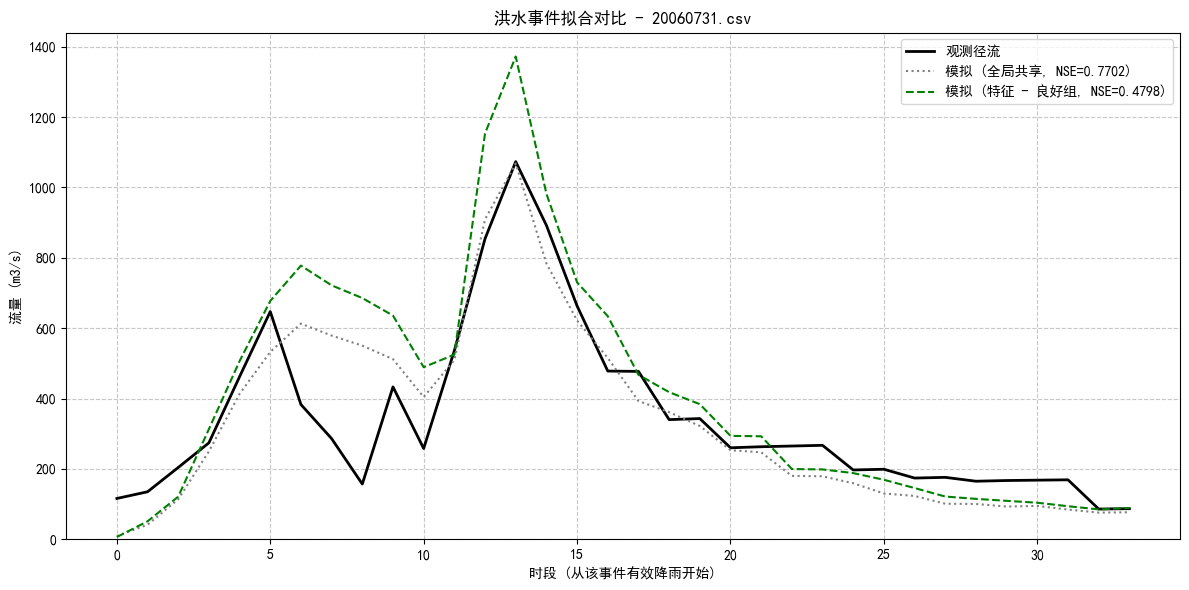

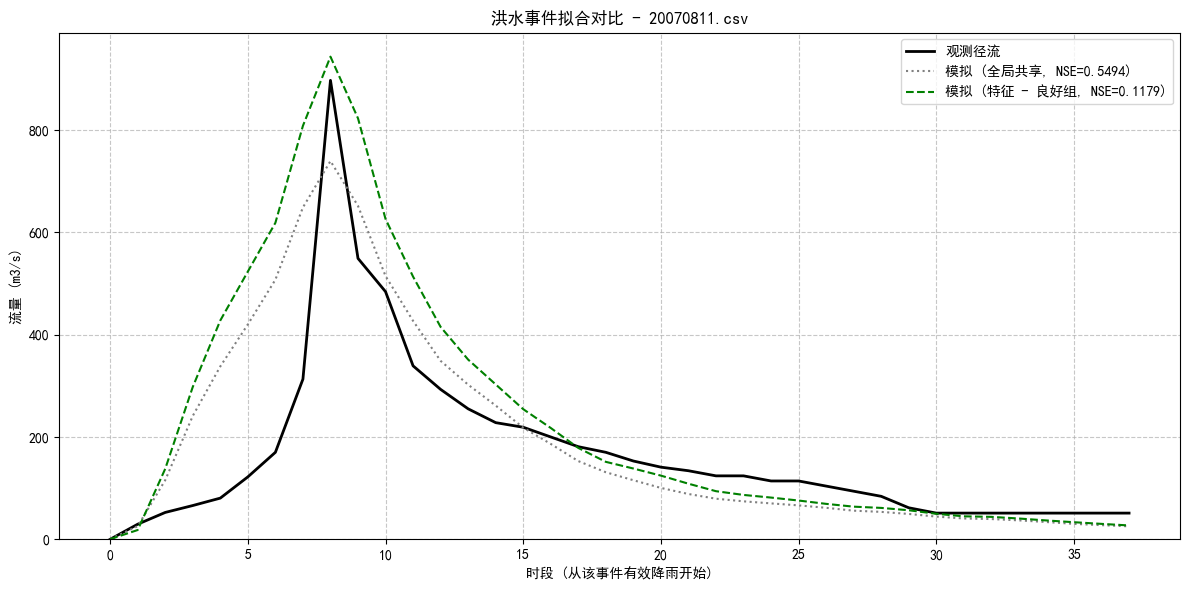

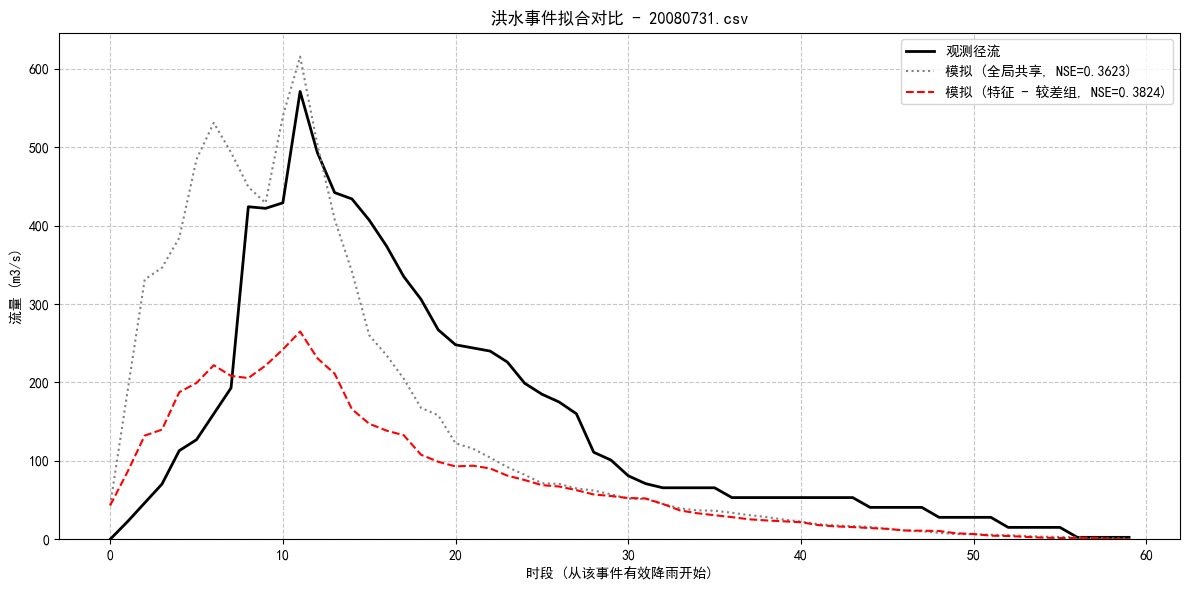

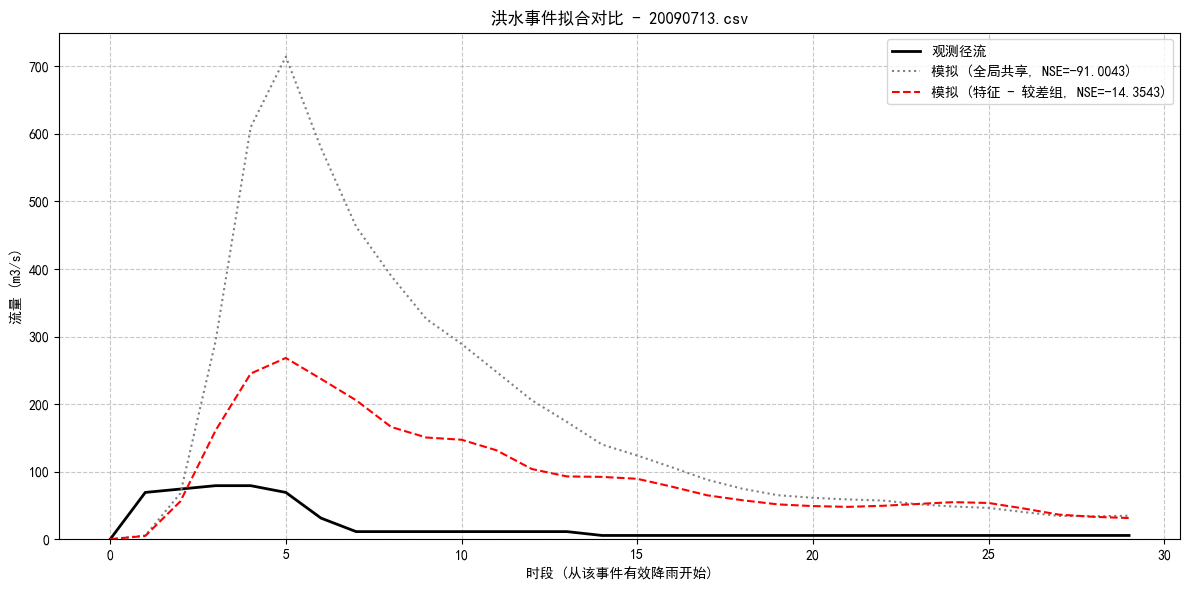

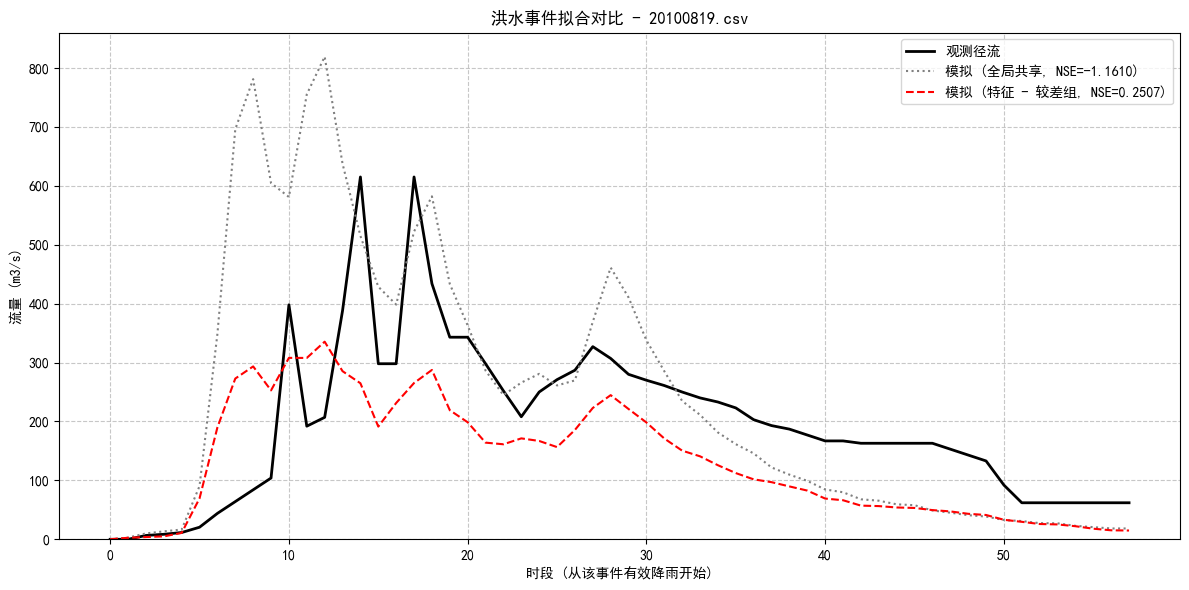

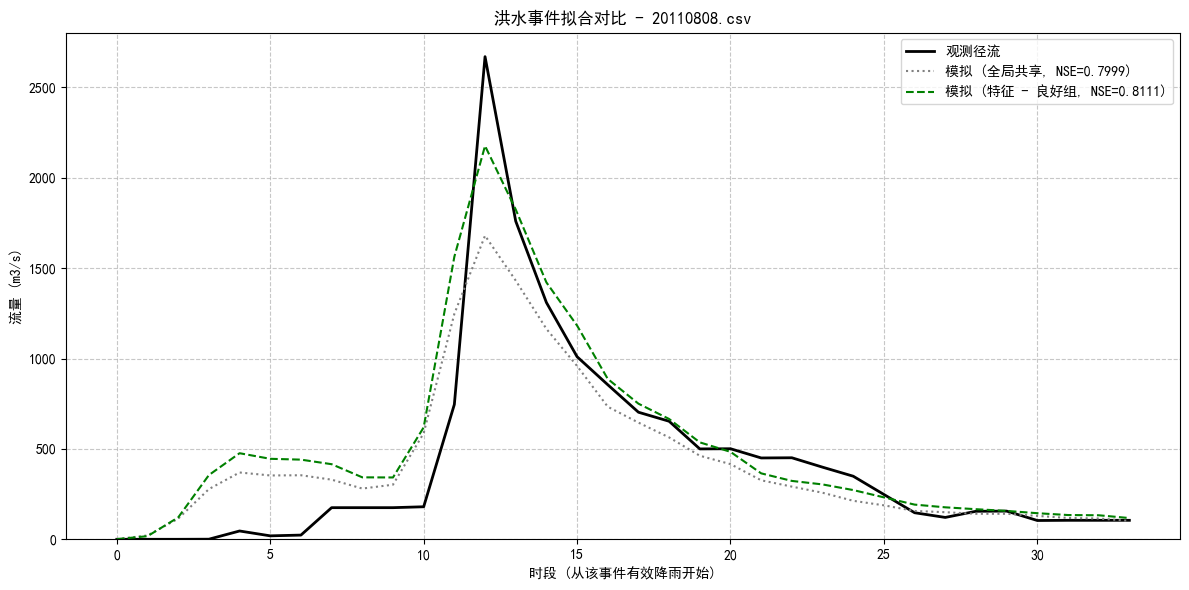

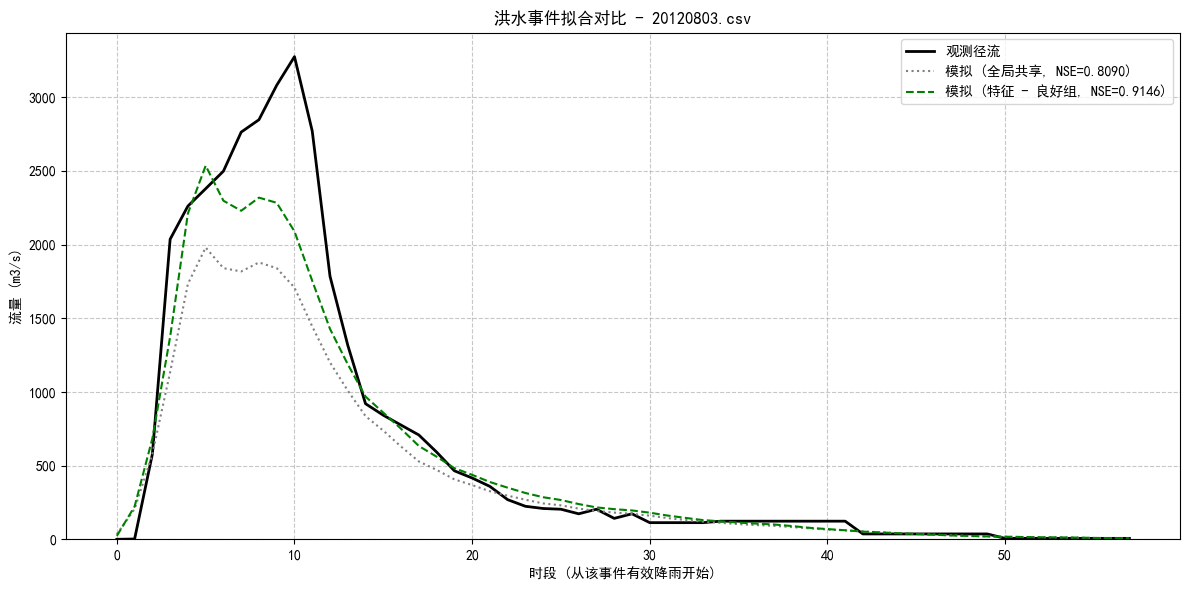

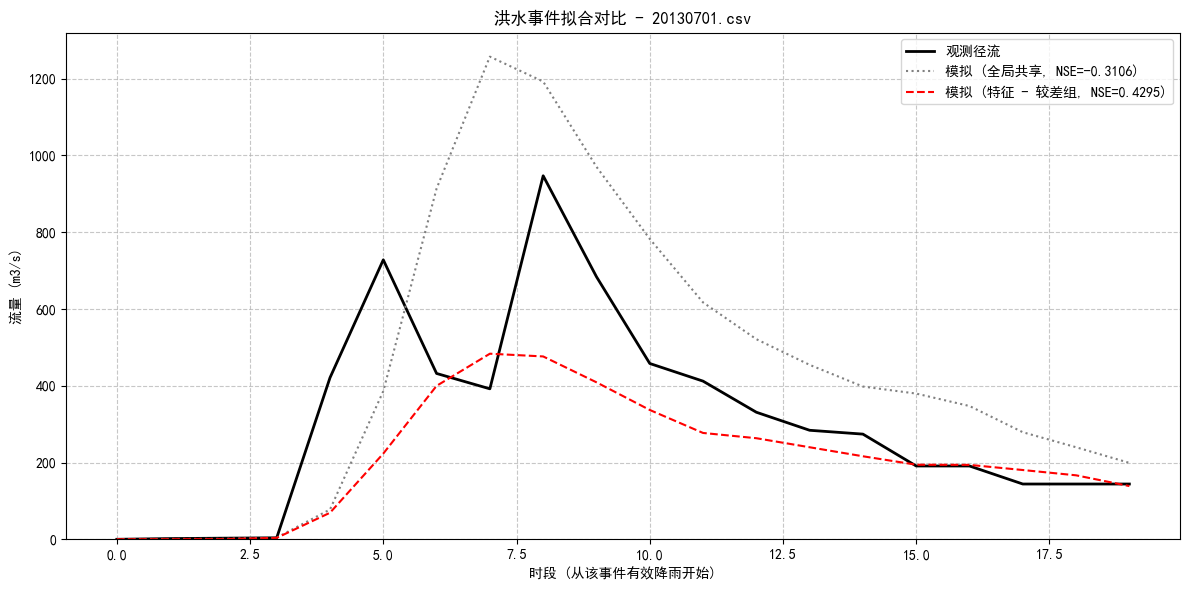

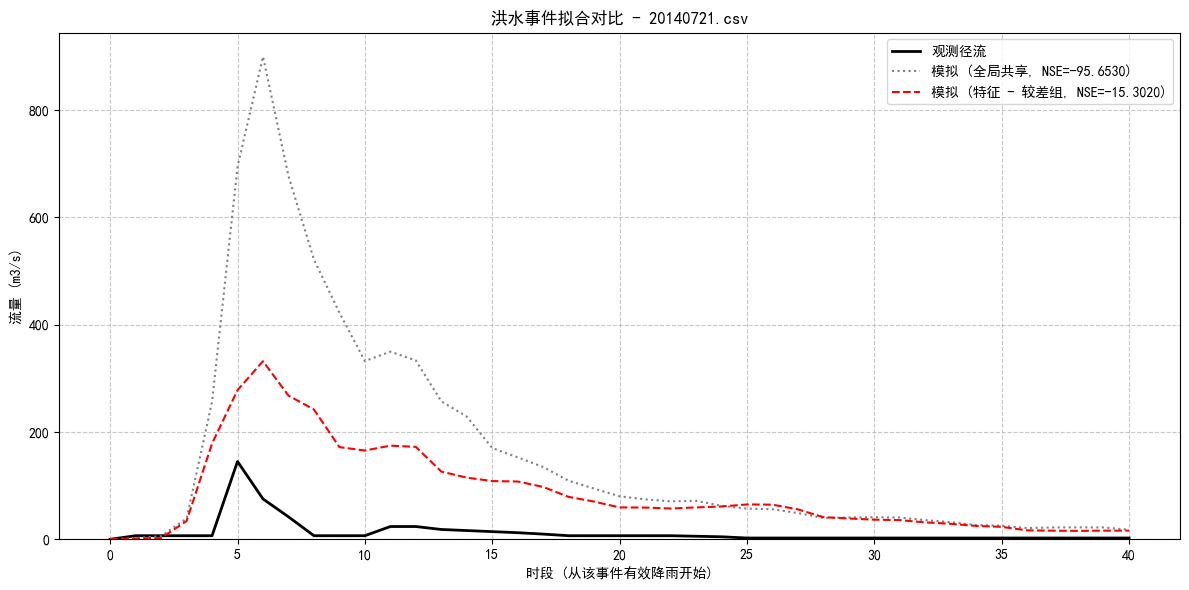

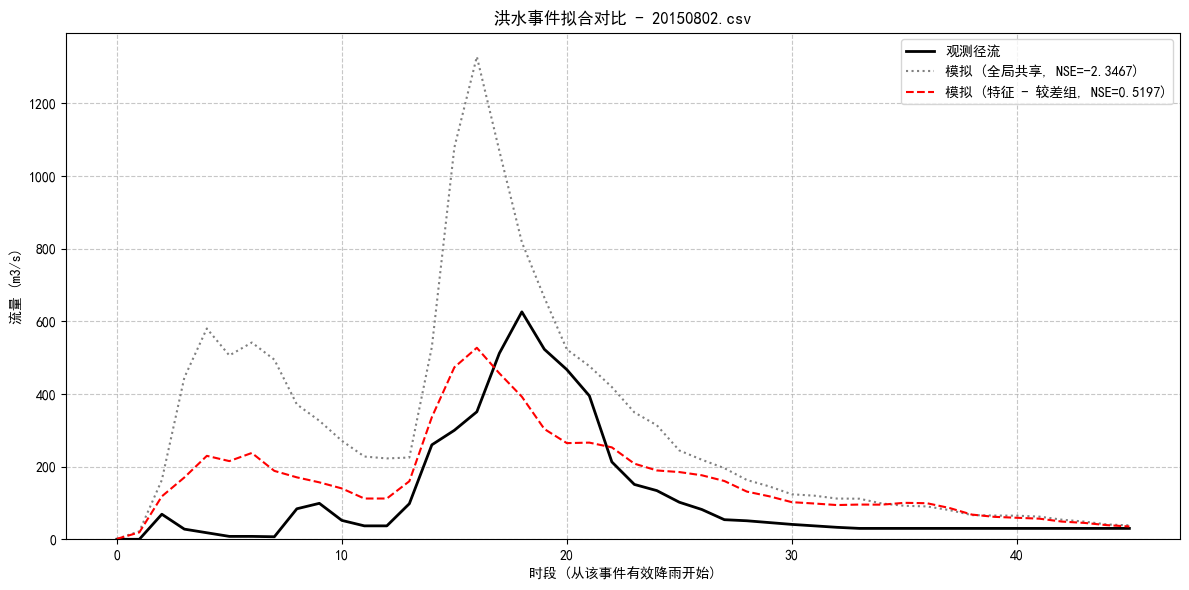

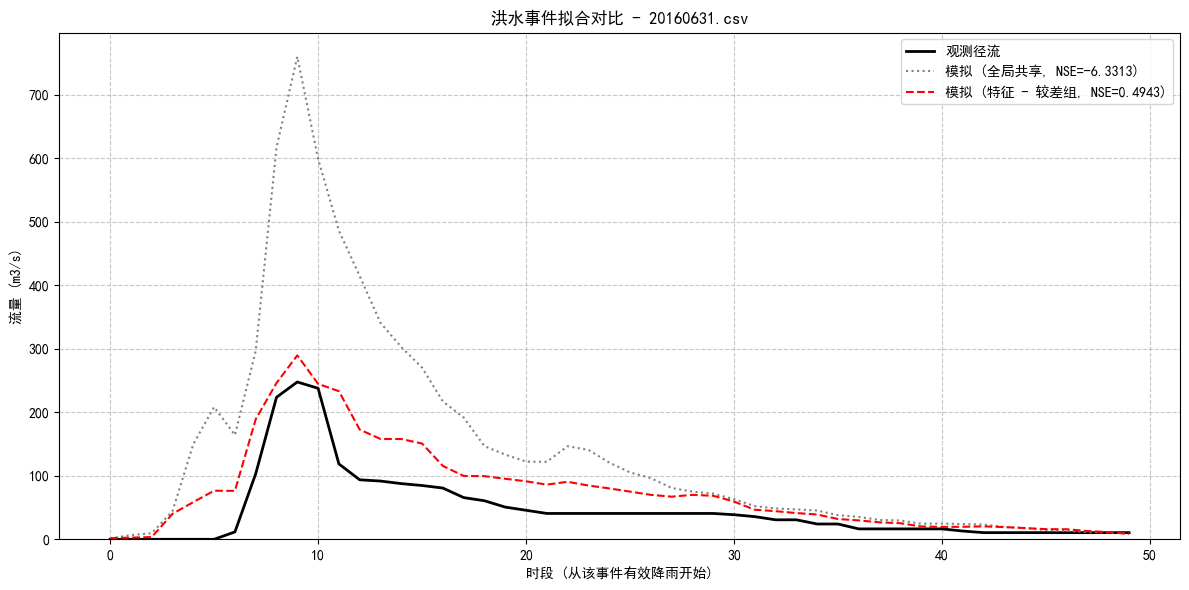

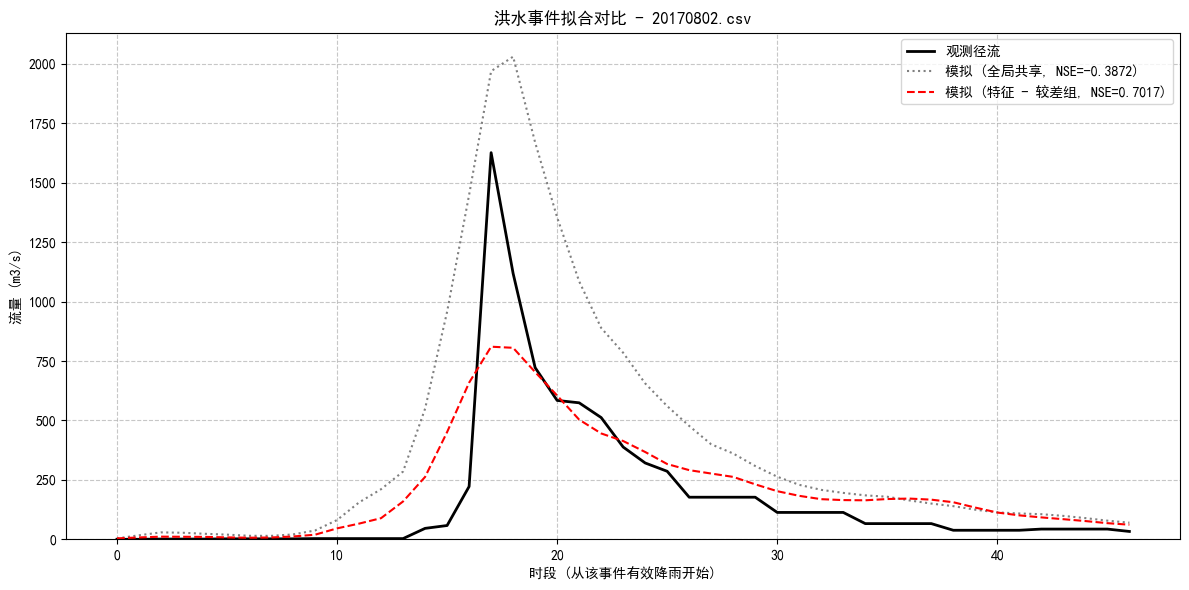


--- 所有事件的对比图绘制完成 ---


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.font_manager import FontProperties
import os

# --- 配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("中文字体 SimHei 未找到，请确保已安装或修改字体设置。")

R_UH = 10.0
DELTA_T_HOURS = 3.0
delta_t_seconds = DELTA_T_HOURS * 3600.0

# --- 辅助函数 (与之前相同) ---
def preprocess_single_event_data(csv_filepath):
    # ... (与之前版本完全相同) ...
    try:
        encodings_to_try = ['utf-8', 'gbk', 'latin1']
        df = None
        for enc in encodings_to_try:
            try:
                df = pd.read_csv(csv_filepath, encoding=enc)
                break
            except UnicodeDecodeError: continue
        if df is None: return None
    except Exception: return None
    time_col = '时间'; net_rain_col = '泰森多边形面雨量'; direct_runoff_col = '分割流量'
    if not all(col in df.columns for col in [time_col, net_rain_col, direct_runoff_col]): return None
    df[net_rain_col] = pd.to_numeric(df[net_rain_col], errors='coerce').fillna(0)
    df[direct_runoff_col] = pd.to_numeric(df[direct_runoff_col], errors='coerce').fillna(0)
    net_rain_full_event = df[net_rain_col].values
    direct_runoff_obs_full_event = df[direct_runoff_col].values
    first_rain_idx, has_effective_rain = 0, False
    for i, r_val in enumerate(net_rain_full_event):
        if r_val > 1e-6: first_rain_idx, has_effective_rain = i, True; break
    if not has_effective_rain: return None
    last_rain_idx = len(net_rain_full_event) - 1
    for i in range(len(net_rain_full_event) - 1, first_rain_idx - 1, -1):
        if net_rain_full_event[i] > 1e-6: last_rain_idx = i; break
    P_eff_event = net_rain_full_event[first_rain_idx : last_rain_idx + 1]
    m_eff_event = len(P_eff_event)
    if m_eff_event == 0: return None
    Q_obs_eff_event = direct_runoff_obs_full_event[first_rain_idx:]
    l_obs_eff_event = len(Q_obs_eff_event)
    n_event_specific = l_obs_eff_event - m_eff_event + 1
    if n_event_specific <= 0: return None
    return {"P_eff": P_eff_event, "Q_obs_eff": Q_obs_eff_event, "m_eff": m_eff_event, "n_specific": n_event_specific, "filepath": csv_filepath}

def convolve_uh(P, U, R_UH_val):
    # ... (与之前版本完全相同) ...
    m_p, n_u = len(P), len(U); len_q = m_p + n_u - 1
    if len_q < 0: len_q = 0 
    Q_sim = np.zeros(len_q)
    P_normalized = P / R_UH_val
    for i in range(m_p):
        if P_normalized[i] > 1e-9:
            for k in range(n_u):
                if (i + k) < len_q: Q_sim[i + k] += P_normalized[i] * U[k]
    return Q_sim

def objective_function_multi_event(U_params, list_of_event_data_for_opt, R_UH_val, 
                                   lambda_smooth, lambda_peak_violation, apply_peak_penalty_flag,
                                   common_n_uh):
    # ... (与之前版本完全相同) ...
    total_fit_loss = 0
    if len(U_params) != common_n_uh: return 1e18 
    for event_data in list_of_event_data_for_opt:
        P_event, Q_event_obs_for_opt = event_data["P_eff"], event_data["Q_obs_for_opt"]
        Q_sim_full_event = convolve_uh(P_event, U_params, R_UH_val)
        Q_sim_compare_event = Q_sim_full_event[:len(Q_event_obs_for_opt)]
        total_fit_loss += np.sum((Q_sim_compare_event - Q_event_obs_for_opt)**2)
    loss_smooth_val = np.sum(np.diff(U_params)**2) if len(U_params) > 1 else 0
    peak_violation_penalty_val = 0
    if apply_peak_penalty_flag and len(U_params) > 2:
        actual_k_peak = np.argmax(U_params)
        for j in range(actual_k_peak):
            if U_params[j+1] < U_params[j] - 1e-6: peak_violation_penalty_val += (U_params[j] - U_params[j+1])**2
        for j in range(actual_k_peak, len(U_params) - 1):
            if U_params[j+1] > U_params[j] + 1e-6: peak_violation_penalty_val += (U_params[j+1] - U_params[j])**2
    return total_fit_loss + lambda_smooth * loss_smooth_val + lambda_peak_violation * peak_violation_penalty_val

def optimize_uh_for_group(events_in_group, group_name, weights):
    # ... (与之前版本完全相同) ...
    print(f"\n--- 正在为组 '{group_name}' 优化特征单位线 ({len(events_in_group)} 场) ---")
    if len(events_in_group) < 3:
        print("事件数量过少，跳过优化。")
        return None, {}
    n_specifics = [d["n_specific"] for d in events_in_group if d["n_specific"] > 0]
    if not n_specifics:
        print("未能确定有效的n_specific，跳过。")
        return None, {}
    n_uh_group = int(np.max(n_specifics))
    if n_uh_group <= 1: n_uh_group = max(3, n_uh_group if n_uh_group > 0 else 3)
    print(f"  单位线长度: {n_uh_group}")
    data_for_opt_group = []
    for event in events_in_group:
        P_eff, Q_obs_eff, m_eff = event["P_eff"], event["Q_obs_eff"], event["m_eff"]
        target_q_len = m_eff + n_uh_group - 1
        if target_q_len < 0: target_q_len = 0
        Q_obs_for_opt = np.zeros(target_q_len)
        len_to_copy = min(len(Q_obs_eff), target_q_len)
        Q_obs_for_opt[:len_to_copy] = Q_obs_eff[:len_to_copy]
        data_for_opt_group.append({"P_eff": P_eff, "Q_obs_for_opt": Q_obs_for_opt, "filepath": event["filepath"]})
    U_initial = np.zeros(n_uh_group)
    bounds = [(0, None) for _ in range(n_uh_group)]
    smoothing = weights['smoothing_factor']; peak_penalty = weights['peak_violation_weight']
    apply_penalty = n_uh_group > 2
    print(f"  使用权重: 平滑={smoothing}, 单峰罚={peak_penalty if apply_penalty else 'N/A'}")
    result_uh = minimize(objective_function_multi_event, U_initial, args=(data_for_opt_group, R_UH, smoothing, peak_penalty, apply_penalty, n_uh_group), method='L-BFGS-B', bounds=bounds, options={'disp': False, 'maxiter': 500, 'ftol': 1e-8, 'gtol': 1e-6})
    U_optimized = result_uh.x if (result_uh.success or result_uh.status in [0,2]) else U_initial
    print(f"  优化{'成功' if (result_uh.success or result_uh.status in [0,2]) else '可能未收敛'}")
    return U_optimized, {"n_uh": n_uh_group}

# --- 新增的NSE计算辅助函数 ---
def calculate_nse(q_obs, q_sim):
    """计算给定观测和模拟序列的NSE值"""
    if len(q_obs) != len(q_sim) or len(q_obs) == 0:
        return np.nan
    
    mean_obs = np.mean(q_obs)
    denominator = np.sum((q_obs - mean_obs)**2)
    
    if denominator == 0:
        return 1.0 if np.allclose(q_sim, q_obs) else -np.inf
    else:
        numerator = np.sum((q_obs - q_sim)**2)
        return 1 - (numerator / denominator)

# --- 主程序 ---
# 1. 数据预处理
data_folder = "data_source/" 
csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
print(f"找到 {len(csv_files)} 个CSV文件...")
all_events_processed_data = [d for d in [preprocess_single_event_data(f) for f in csv_files] if d]
if not all_events_processed_data: exit()
print(f"成功预处理 {len(all_events_processed_data)} 场洪水事件。")

# ==============================================================================
# --- 第一阶段：推求全局共享单位线 ---
# ==============================================================================
global_weights = {'smoothing_factor': 0.1, 'peak_violation_weight': 100.0}
U_optimized_shared, shared_uh_info = optimize_uh_for_group(all_events_processed_data, "全局共享", global_weights)
if U_optimized_shared is None: exit()
    
# 使用全局单位线评估所有事件
shared_uh_evaluation = []
for event_data in all_events_processed_data:
    P_event, Q_obs_event_full = event_data["P_eff"], event_data["Q_obs_eff"]
    Q_sim_event_full = convolve_uh(P_event, U_optimized_shared, R_UH)
    Q_sim_event_compare = Q_sim_event_full[:len(Q_obs_event_full)]
    nse_event = calculate_nse(Q_obs_event_full, Q_sim_event_compare)
    shared_uh_evaluation.append({"文件名": os.path.basename(event_data["filepath"]), "NSE": nse_event, "filepath": event_data["filepath"]})

# ==============================================================================
# --- 第二阶段：基于NSE进行二次分类 ---
# ==============================================================================
NSE_THRESHOLD = 0.5 
good_fit_events_data, poor_fit_events_data = [], []
for result in shared_uh_evaluation:
    event_data = next((data for data in all_events_processed_data if data["filepath"] == result["filepath"]), None)
    if event_data:
        if pd.notna(result["NSE"]) and result["NSE"] >= NSE_THRESHOLD:
            good_fit_events_data.append(event_data)
        else:
            poor_fit_events_data.append(event_data)
print(f"\n--- 基于NSE={NSE_THRESHOLD}的二次分类结果 ---")
print(f"拟合良好组事件数量: {len(good_fit_events_data)} 场")
print(f"拟合较差组事件数量: {len(poor_fit_events_data)} 场")

# ==============================================================================
# --- 第三阶段：为每个新类别优化特征单位线 ---
# ==============================================================================
group_weights = {
    "GoodFit": {'smoothing_factor': 0.05, 'peak_violation_weight': 50.0},
    "PoorFit": {'smoothing_factor': 0.2, 'peak_violation_weight': 500.0} 
}
U_optimized_goodfit, goodfit_uh_info = optimize_uh_for_group(good_fit_events_data, "拟合良好组", group_weights["GoodFit"])
U_optimized_poorfit, poorfit_uh_info = optimize_uh_for_group(poor_fit_events_data, "拟合较差组", group_weights["PoorFit"])

# ==============================================================================
# --- 第四阶段：为每一场洪水绘制最终的对比图 ---
# ==============================================================================
print("\n--- 正在为每一场洪水生成最终的拟合对比图 ---")
for event_data in all_events_processed_data:
    event_filename = os.path.basename(event_data["filepath"])
    P_event = event_data["P_eff"]
    Q_obs_event = event_data["Q_obs_eff"]

    # 1. 使用全局共享单位线模拟并计算NSE
    Q_sim_shared = convolve_uh(P_event, U_optimized_shared, R_UH)
    Q_sim_shared_plot = Q_sim_shared[:len(Q_obs_event)]
    nse_shared = calculate_nse(Q_obs_event, Q_sim_shared_plot)
    label_shared = f'模拟 (全局共享, NSE={nse_shared:.4f})'

    # 2. 判断类别并使用特征单位线模拟并计算NSE
    Q_sim_characteristic_plot = None
    label_characteristic = '模拟 (特征单位线 - 未优化)'
    
    category_of_event = "未知"
    if any(os.path.basename(d["filepath"]) == event_filename for d in good_fit_events_data):
        category_of_event = "良好组"
        if U_optimized_goodfit is not None:
            Q_sim_characteristic = convolve_uh(P_event, U_optimized_goodfit, R_UH)
            Q_sim_characteristic_plot = Q_sim_characteristic[:len(Q_obs_event)]
            nse_char = calculate_nse(Q_obs_event, Q_sim_characteristic_plot)
            label_characteristic = f'模拟 (特征 - {category_of_event}, NSE={nse_char:.4f})'
            
    elif any(os.path.basename(d["filepath"]) == event_filename for d in poor_fit_events_data):
        category_of_event = "较差组"
        if U_optimized_poorfit is not None:
            Q_sim_characteristic = convolve_uh(P_event, U_optimized_poorfit, R_UH)
            Q_sim_characteristic_plot = Q_sim_characteristic[:len(Q_obs_event)]
            nse_char = calculate_nse(Q_obs_event, Q_sim_characteristic_plot)
            label_characteristic = f'模拟 (特征 - {category_of_event}, NSE={nse_char:.4f})'

    # 3. 绘图
    plt.figure(figsize=(12, 6))
    
    plt.plot(np.arange(len(Q_obs_event)), Q_obs_event, 
             label='观测径流', color='black', linewidth=2)
    
    plt.plot(np.arange(len(Q_sim_shared_plot)), Q_sim_shared_plot, 
             label=label_shared, color='gray', linestyle=':')
    
    if Q_sim_characteristic_plot is not None:
        color_map = {"良好组": "green", "较差组": "red"}
        plt.plot(np.arange(len(Q_sim_characteristic_plot)), Q_sim_characteristic_plot, 
                 label=label_characteristic, 
                 color=color_map.get(category_of_event, 'purple'), linestyle='--')

    plt.title(f'洪水事件拟合对比 - {event_filename}')
    plt.xlabel('时段 (从该事件有效降雨开始)')
    plt.ylabel('流量 (m3/s)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()

print("\n--- 所有事件的对比图绘制完成 ---")